In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from pandas.io.json import json_normalize
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn.model_selection import train_test_split, KFold
import os

# Any results you write to the current directory are saved as output.

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:


#loading of data
json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
train = pd.read_csv("train.csv",converters={column: json.loads for column in json_columns}, dtype={'fullVisitorId': 'str'})
test = pd.read_csv("test.csv",converters={column: json.loads for column in json_columns}, dtype={'fullVisitorId': 'str'})
train_id = train["fullVisitorId"].values
test_id = test["fullVisitorId"].values




In [3]:
#train_arav = pd.read_csv("train.csv",nrows=10, dtype={'fullVisitorId': 'str'})
train["fullVisitorId"].head(5)

0    1131660440785968503
1     377306020877927890
2    3895546263509774583
3    4763447161404445595
4      27294437909732085
Name: fullVisitorId, dtype: object

In [4]:
#parsing the json columns for training data
for column in json_columns:
    column_in_json = json_normalize(train[column])
    column_in_json.columns = [f"{column}_{subcolumn}" for subcolumn in column_in_json.columns]
    train = train.drop(column, axis=1).merge(column_in_json, right_index=True, left_index=True)
    
#parsing the json columns for testing data
for column in json_columns:
    column_in_json = json_normalize(test[column])
    column_in_json.columns = [f"{column}_{subcolumn}" for subcolumn in column_in_json.columns]
    test = test.drop(column, axis=1).merge(column_in_json, right_index=True, left_index=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device_browser                                       903653 non-null object
device_browserSize                                   903653 non-null object
device_browserVersion                                903653 non-null object
device_deviceCategory                                9036

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 53 columns):
channelGrouping                                      804684 non-null object
date                                                 804684 non-null int64
fullVisitorId                                        804684 non-null object
sessionId                                            804684 non-null object
socialEngagementType                                 804684 non-null object
visitId                                              804684 non-null int64
visitNumber                                          804684 non-null int64
visitStartTime                                       804684 non-null int64
device_browser                                       804684 non-null object
device_browserSize                                   804684 non-null object
device_browserVersion                                804684 non-null object
device_deviceCategory                                8046

In [7]:
set(train.columns).difference(set(test.columns))

{'totals_transactionRevenue', 'trafficSource_campaignCode'}

In [8]:
train_constant_columns = [column for column in train.columns if train[column].nunique(dropna=False)==1 ]
test_constant_columns = [column for column in test.columns if test[column].nunique(dropna=False) == 1]
print(f" {set(train_constant_columns).intersection(set(test_constant_columns)) == set(train_constant_columns)}")
#Removed columns with unique value

 True


In [9]:
train_constant_columns

['socialEngagementType',
 'device_browserSize',
 'device_browserVersion',
 'device_flashVersion',
 'device_language',
 'device_mobileDeviceBranding',
 'device_mobileDeviceInfo',
 'device_mobileDeviceMarketingName',
 'device_mobileDeviceModel',
 'device_mobileInputSelector',
 'device_operatingSystemVersion',
 'device_screenColors',
 'device_screenResolution',
 'geoNetwork_cityId',
 'geoNetwork_latitude',
 'geoNetwork_longitude',
 'geoNetwork_networkLocation',
 'totals_visits',
 'trafficSource_adwordsClickInfo.criteriaParameters']

In [10]:
train.drop(train_constant_columns, axis=1, inplace=True)
test.drop(test_constant_columns, axis=1, inplace=True)

In [ ]:
not_used_cols = [ "sessionId", "visitId",  'trafficSource_referralPath']
train = train.drop(not_used_cols, axis=1)

In [11]:
# converting columns into more reasonable format
num_cols = ['totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews']
print(num_cols)

for col in num_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

['totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews']


In [12]:
num_cols

['totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews']

In [13]:

train.drop(['trafficSource_campaignCode'], axis=1, inplace=True)


In [14]:
def replace_with_0(val):
    if not val:
        return 0
    return val

In [15]:
train["totals_newVisits"] = train["totals_newVisits"].apply(replace_with_0)
train["totals_bounces"] = train["totals_bounces"].apply(replace_with_0)
train["totals_pageviews"] = train["totals_pageviews"].apply(replace_with_0)


In [21]:
train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype(float)

In [16]:
train["date"] = pd.to_datetime(train["date"],format="%Y%m%d")
train["visitStartTime"] = pd.to_datetime(train["visitStartTime"],unit='s')
train["day_of_week"] = train["visitStartTime"].dt.dayofweek
train["hour"] = train["visitStartTime"].dt.hour
train["day"] = train["visitStartTime"].dt.day
train["month"] = train["visitStartTime"].dt.month
train["weekday"] = train["visitStartTime"].dt.weekday

test["date"] = pd.to_datetime(test["date"],format="%Y%m%d")
test["visitStartTime"] = pd.to_datetime(test["visitStartTime"],unit='s')
test["day_of_week"] = test["visitStartTime"].dt.dayofweek
test["hour"] = test["visitStartTime"].dt.hour
test["day"] = test["visitStartTime"].dt.day
test["month"] = test["visitStartTime"].dt.month
test["weekday"] = test["visitStartTime"].dt.weekday

In [ ]:
for i in ['totals_bounces', 'totals_hits','totals_newVisits', 'totals_pageviews']:
    train[i] = train[i].fillna(0).astype(float)
    test[i] = test[i].fillna(0).astype(float)
    

In [22]:
corr_train = train[['channelGrouping', 'totals_pageviews',
       'visitNumber', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_transactionRevenue', 'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source']]

In [25]:
train['totals_transactionRevenue'] = train['totals_transactionRevenue'].fillna(0).astype(float)

In [ ]:
correlation_map = np.corrcoef(train[columns- ].values.T)
sns.set(font_scale=1.0)
fig, ax = plt.subplots(figsize=(10,10))
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.show()

In [45]:
train["PurchasedOrNot"] = train["totals_transactionRevenue"].apply(lambda x: 1 if x > 0.0 else 0)

In [46]:
trans_prob = train.groupby('fullVisitorId')['PurchasedOrNot'].agg(['size','sum'])


In [56]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source', 'day_of_week', 'hour', 'day', 'month',
 

In [65]:
corr_mat=train[['day_of_week', 'hour', 'day', 'month','weekday', 'totals_bounces', 'totals_hits','totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue']]





In [66]:
import seaborn as sns

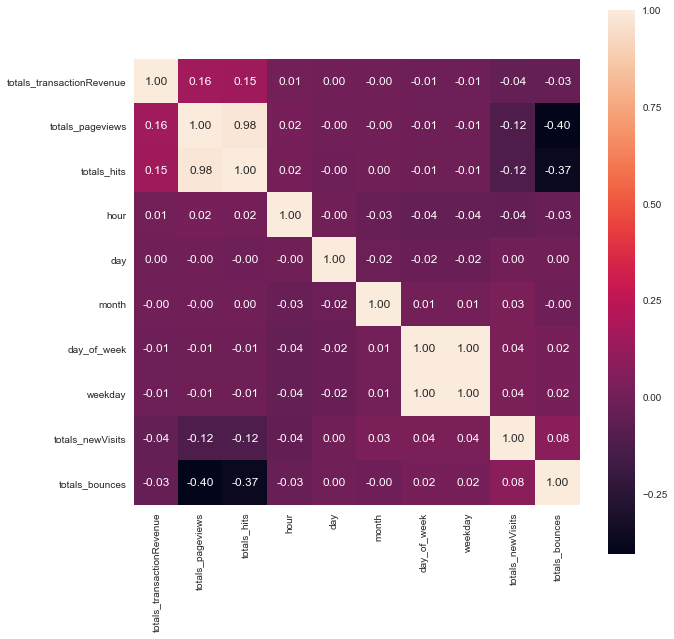

In [67]:
correlation = corr_mat.corr(method='spearman')
columns = correlation.nlargest(10,'totals_transactionRevenue').index
correlation_map = np.corrcoef(train[columns].values.T)
sns.set(font_scale=1.0)
fig, ax = plt.subplots(figsize=(10,10))
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.show()

In [ ]:
train['totals_transactionRevenue'] = train['totals_transactionRevenue'].fillna(0).astype(float)

In [48]:
trans_prob["probability"] = trans_prob["sum"]/trans_prob["size"]

In [49]:
trans_prob = trans_prob.sort_values(by="probability")

In [52]:
top_users = trans_prob[trans_prob["sum"]>5]

In [53]:
top_users.tail(10)

,size,sum,probability
fullVisitorId,,,
1814166460229302850,15,7,0.466667
2402527199731150932,31,15,0.483871
2446685875964479851,11,6,0.545455
7463172420271311409,16,9,0.562500
0777922178356486144,10,6,0.600000
8657427332734176422,10,6,0.600000
2411322974724385937,11,7,0.636364
3857043812510146001,9,6,0.666667
4984366501121503466,24,16,0.666667


In [68]:

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


def bar_graph(region, color):
    graph = go.Bar(x=region.index[::-1], y=region.values[::-1],marker=dict(color=color))
    return graph

In [81]:

continent_rev = train.groupby('geoNetwork_continent')['PurchasedOrNot'].agg(['size'])
continent_rev.columns = ["Non-zero revenue"]

graph = [bar_graph(continent_rev["Non-zero revenue"].head(10), 'rgb(0,255,255,0.6)')]
py.iplot(graph)

In [82]:
continent_size = train.groupby('geoNetwork_continent')['PurchasedOrNot'].agg(['sum'])
continent_size.columns = ["size"]
graph = [ bar_graph(continent_size["size"].head(10), 'rgb(0,255,255,0.6)')]
py.iplot(graph)

In [84]:
# Sub-continent
sub_continent_size = train.groupby('geoNetwork_subContinent')['totals_transactionRevenue'].agg(['size'])
sub_continent_size.columns = ["size"]

graph = [bar_graph(sub_continent_size["size"], 'pink')]

py.iplot(graph)

In [83]:
# Sub-continent
sub_continent_revenue = train.groupby('geoNetwork_subContinent')['PurchasedOrNot'].agg(['sum'])
sub_continent_revenue.columns = [ "Non-zero revenue"]

graph = [bar_graph(sub_continent_revenue["Non-zero revenue"], 'pink')]
py.iplot(graph)

In [114]:
from plotly.offline import init_notebook_mode, plot, download_plotlyjs, iplot
country_count = train["geoNetwork_country"].value_counts()
data = [dict(
    type = "choropleth",
    locations = country_count.index.values,
    locationmode = "country names",
    z = country_count.values,
    text = country_count.index.values,
    colorscale = "Rainbow",
    reversescale = True,
    marker = dict(line = dict(color = "rgb(180,180,180)", width = 0.5)),
    colorbar = dict(title="Count")
)]
layout = dict(title="Distribution of data by country (total train data)", height=600, width=800, geo=dict(showframe=False))
fig = dict(data=data, layout=layout)
iplot(fig, validate=False)

In [86]:
data_by_country_count = train[train['totals_transactionRevenue'].astype("float32")>0]['geoNetwork_country'].value_counts()
data = [dict(
    type = "choropleth",
    locations = data_by_country_count.index.values,
    locationmode = "country names",
    z = data_by_country_count.values,
    text = data_by_country_count.index.values,
    colorscale = "Rainbow",
    autocolorscale = False,
    reversescale = True,
    marker = dict(line = dict(color = "rgb(180,180,180)", width = 0.5)),
    colorbar = dict(title="Count")
)]
layout = dict(title="Distribution of data by country with non-zero revenue", height=600, width=800, geo=dict(showframe=False))
fig = dict(data=data, layout=layout)
iplot(fig, validate=False)

In [87]:
graph = go.Histogram(x=train[train["totals_transactionRevenue"].astype("float32")>0]["totals_transactionRevenue"].astype("float32").apply(np.log), 
                     marker=dict(color="pink"))
g = [graph]
l = go.Layout(title="Transaction revenue distribution", xaxis=dict(title="log of transaction Revenue"),
                   yaxis=dict(title="Count"), plot_bgcolor='white')
figure = go.Figure(data=g, layout=l)
iplot(figure)

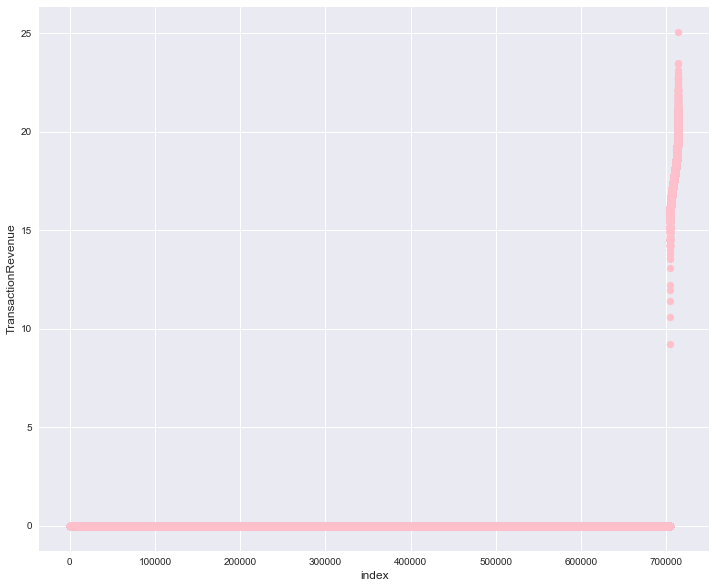

In [92]:

gdf = train.groupby("fullVisitorId")["totals_transactionRevenue"].sum().reset_index()

plt.figure(figsize=(12,10))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals_transactionRevenue"].values)),c='pink')
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [113]:
weekday_data = train.groupby('weekday').agg({"totals_transactionRevenue" : "mean"}).reset_index()
hour_data = train.groupby('hour').agg({"totals_transactionRevenue" : "mean"}).reset_index()

fig = tools.make_subplots(rows=2, cols=1, subplot_titles=["Monthly Average Revenue", "Hourly Average Revenue"], print_grid=False)

g1 = go.Bar(x = ['Mon','Tues','Wed','Thur','Fri','Sat','Sun'], marker=dict(color="pink", opacity=0.5), y = weekday_data.totals_transactionRevenue)
g2 = go.Bar(x = hour_data.hour, marker=dict(color="yellow", opacity=0.5), y = hour_data.totals_transactionRevenue)


fig.append_trace(g1, 1, 1)
fig.append_trace(g2, 2, 1)

fig['layout'].update(height=800, showlegend=False)
iplot(fig)

In [ ]:
external_dataset = pd.read_csv("internet_population.csv")
external_dataset.dropna(how = 'any', axis = 'rows', inplace = True)
external_dataset = external_dataset[['Country','InternetUsers','Population']]
external_dataset.rename(columns={'InternetUsers': 'Num_of_internet_users','Country': 'geoNetwork_country'}, inplace=True)
external_dataset.info()
train = pd.merge(train, external_dataset, on='geoNetwork_country')
train.info()

In [21]:
target = train['totals_transactionRevenue'].fillna(0).astype(float)
target = target.apply(lambda x: np.log(x) if x > 0 else x)
train = train.drop('totals_transactionRevenue', axis=1)

In [25]:
from sklearn.preprocessing import LabelEncoder

#object cols
convert_to_category_columns = list(train.select_dtypes(include=['object', 'bool', 'datetime']).columns)
for c in convert_to_category_columns:

    le = LabelEncoder()
    train_vals = list(train[c].values.astype(str))
    test_vals = list(test[c].values.astype(str))
    
    le.fit(train_vals + test_vals)
    
    train[c] = le.transform(train_vals)
    test[c] = le.transform(test_vals)

In [7]:
# map_of_unknown_values = {"(not provided)": "missing", "(not set)": "missing", "(none)": "missing", "not available in demo dataset": "missing", "unknown.unknown": "missing"}
# train = train.fillna("missing")
# test = test.fillna("missing")
# for i in train.columns:
#     train[i] = train[i].astype(str).replace(map_of_unknown_values)
# for i in test.columns:
#     test[i] = test[i].astype(str).replace(map_of_unknown_values)

In [24]:
def lgb_train(X, y, test_X, params):
    kf = KFold(n_splits=5, shuffle=True)
    prediction_test = 0
    prediction_train = 0
    for dev_ind, val_ind in kf.split(X):
        train_x, valid_x = X.iloc[dev_ind,:], X.iloc[val_ind,:]
        train_y, valid_y = y[dev_index], y[val_index]
        lgtrain = lgb.Dataset(train_x, train_y,categorical_feature=list(convert_to_category_columns))
        lgvalid = lgb.Dataset(valid_x, valid_y,categorical_feature=list(convert_to_category_columns))
        model = lgb.train(params, lgtrain, 2000, valid_sets=[lgvalid], early_stopping_rounds=100, verbose_eval=100)
        pred_test_iter = model.predict(test_X, num_iteration=model.best_iteration)
        pred_test_iter[pred_test_iter<0]=0
        prediction_test+=pred_test_iter
        pred_train_iter = model.predict(X, num_iteration=model.best_iteration)
        pred_train_iter[pred_train_iter<0]=0
        prediction_train+=pred_train_iter
    prediction_test /= 5.
    prediction_train  /= 5.
    return prediction_train, prediction_test

In [25]:
lgb_params = {'objective': 'regression', 'metric': 'rmse',  'subsample' : 0.8, 'colsample_bytree' : 0.8,
              'verbosity': -1,'max_depth': 8, 'min_child_samples': 21,'reg_alpha': 1, 'reg_lambda': 1,'learning_rate': 0.1 }

In [26]:
lgb_train, lgb_test = lgb_train(train, target, test, lgb_params)

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.65133
Early stopping, best iteration is:
[82]	valid_0's rmse: 1.65109
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.6295
[200]	valid_0's rmse: 1.63029
Early stopping, best iteration is:
[161]	valid_0's rmse: 1.62885
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.63453
[200]	valid_0's rmse: 1.63501
Early stopping, best iteration is:
[134]	valid_0's rmse: 1.63326
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.61117
Early stopping, best iteration is:
[62]	valid_0's rmse: 1.61025
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.6427
Early stopping, best iteration is:
[83]	valid_0's rmse: 1.64157


In [27]:
result = pd.DataFrame({"fullVisitorId":test_id})
lgb_test[lgb_test<0] = 0
result["PredictedLogOfTransactionRevenue"] = np.expm1(lgb_test)
result = result.groupby("fullVisitorId")["PredictedLogOfTransactionRevenue"].sum().reset_index()
result.columns = ["fullVisitorId", "PredictedLogOfTransactionRevenue"]
result["PredictedLogOfTransactionRevenue"] = np.log1p(result["PredictedLogOfTransactionRevenue"])
result.to_csv("baseline_lgb4.csv", index=False)

In [36]:
def xgb_train(X, y, test_X, params):
    kf = KFold(n_splits=5, shuffle=True)
    prediction_test = 0
    prediction_train = 0
    for dev_index, val_index in kf.split(train):
        train_x, valid_x = X.loc[dev_index,:], X.loc[val_index,:]
        train_y, valid_y = y[dev_index], y[val_index]
        xgb_train = xgb.DMatrix(train_x, train_y)
        xgb_val = xgb.DMatrix(valid_x, valid_y)
        xgb_submit = xgb.DMatrix(test_X)
        xgb_submit_train = xgb.DMatrix(X)
        xgb_model = xgb.train(params, xgb_train, 
                          num_boost_round=1000,
                          evals= [(xgb_train, 'train'), (xgb_val, 'valid')],
                          early_stopping_rounds=50
                         )
        pred_test = xgb_model.predict(xgb_submit, ntree_limit=xgb_model.best_ntree_limit)
        pred_train = xgb_model.predict(xgb_submit_train, ntree_limit=xgb_model.best_ntree_limit)
        pred_test[pred_test<0]=0
        pred_train[pred_train<0]=0
        prediction_test += pred_test
        prediction_train += pred_train
    prediction_test /= 5.
    prediction_train /= 5.
    return  prediction_train, prediction_test

In [37]:
params_xgb = {'objective': 'reg:linear','booster': 'gbtree','num_leaves' : 31,'learning_rate' : 0.03,'n_estimators' : 1000,
        'subsample' : .9,'eta' : 0.025,'lamba' : 1,'max_depth' : 7,'gamma' : 0,'colsample_bytree' : 0.8,'colsample_bylevel' : 0.632,
        'random_state' : 1,'n_jobs' : 20,'alpha' : 0,'lambda' : 5, 'min_child_weight' : 5}



In [38]:
xgb_train, xgb_test = xgb_train(train, target, test, params_xgb)

[0]	train-rmse:1.99894	valid-rmse:2.02158
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:1.59436	valid-rmse:1.65108
[200]	train-rmse:1.54461	valid-rmse:1.63345
[300]	train-rmse:1.51427	valid-rmse:1.62919
[400]	train-rmse:1.4889	valid-rmse:1.62613
[500]	train-rmse:1.46698	valid-rmse:1.62535
Stopping. Best iteration:
[456]	train-rmse:1.47591	valid-rmse:1.62519

[0]	train-rmse:2.00317	valid-rmse:2.00434
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:1.59915	valid-rmse:1.63396
[200]	train-rmse:1.55019	valid-rmse:1.61527
[300]	train-rmse:1.5195	valid-rmse:1.6082
[400]	train-rmse:1.49379	valid-rmse:1.60578
[500]	train-rmse:1.47279	valid-rmse:1.60464
Stopping. Best iteration:
[508]	train-rmse:1.47104	valid-rmse:1.60454

[0]	train-rmse:1.9999	valid-rmse:2.01814
Multip

In [39]:
result = pd.DataFrame({"fullVisitorId":test_id})
xgb_test[xgb_test<0] = 0
result["PredictedLogOfTransactionRevenue"] = np.expm1(xgb_test)
result = result.groupby("fullVisitorId")["PredictedLogOfTransactionRevenue"].sum().reset_index()
result.columns = ["fullVisitorId", "PredictedLogOfTransactionRevenue"]
result["PredictedLogOfTransactionRevenue"] = np.log1p(result["PredictedLogOfTransactionRevenue"])
result.to_csv("baseline_xgb4.csv", index=False)

In [48]:
def cat_train(X, y, test_X):
    kf = KFold(n_splits=5, shuffle=True)
    prediction_test = 0
    prediction_train = 0
    for dev_index, val_index in kf.split(train):
        train_x, valid_x = X.loc[dev_index,:], X.loc[val_index,:]
        train_y, valid_y = y[dev_index], y[val_index]
        model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,depth=5,eval_metric='RMSE',random_seed = 50,bagging_temperature = 0.2,
                             od_type='Iter')
        model.fit(train_x, train_y, eval_set=(valid_x, valid_y),use_best_model=True,verbose=True, 
                  cat_features= [i for i in range(len(train.columns)) if train.columns[i] in convert_to_category_columns])
        pred_test = model.predict(test_X)
        pred_test[pred_test<0]=0
        prediction_test += pred_test
        pred_train = model.predict(X)
        pred_train[pred_train<0]=0
        prediction_train += pred_train
    
    prediction_train /= 5.
    prediction_test /= 5.
    return prediction_train, prediction_test

In [49]:
cat_train, cat_test = cat_train(train, target, test)

0:	learn: 1.9949728	test: 2.0181103	best: 2.0181103 (0)	total: 1.12s	remaining: 18m 41s
50:	learn: 1.7290062	test: 1.7529930	best: 1.7529930 (50)	total: 43.7s	remaining: 13m 32s
100:	learn: 1.6713286	test: 1.7102529	best: 1.7102529 (100)	total: 1m 29s	remaining: 13m 12s
150:	learn: 1.6389190	test: 1.6911555	best: 1.6911555 (150)	total: 2m 14s	remaining: 12m 36s
200:	learn: 1.6145512	test: 1.6792733	best: 1.6792733 (200)	total: 3m 1s	remaining: 12m 1s
250:	learn: 1.5975460	test: 1.6728775	best: 1.6728775 (250)	total: 3m 46s	remaining: 11m 16s
300:	learn: 1.5844774	test: 1.6676705	best: 1.6676479 (299)	total: 4m 33s	remaining: 10m 35s
350:	learn: 1.5684214	test: 1.6629929	best: 1.6629929 (350)	total: 5m 17s	remaining: 9m 46s
400:	learn: 1.5576457	test: 1.6602230	best: 1.6602205 (399)	total: 6m 1s	remaining: 9m
450:	learn: 1.5458555	test: 1.6565243	best: 1.6565243 (450)	total: 6m 47s	remaining: 8m 16s
500:	learn: 1.5366931	test: 1.6545032	best: 1.6545032 (500)	total: 7m 31s	remaining: 7m 

0:	learn: 1.9992692	test: 2.0006824	best: 2.0006824 (0)	total: 1s	remaining: 16m 42s
50:	learn: 1.7355277	test: 1.7403370	best: 1.7403370 (50)	total: 44.1s	remaining: 13m 40s
100:	learn: 1.6838227	test: 1.6960945	best: 1.6960945 (100)	total: 1m 27s	remaining: 12m 54s
150:	learn: 1.6511696	test: 1.6725903	best: 1.6725903 (150)	total: 2m 10s	remaining: 12m 13s
200:	learn: 1.6265746	test: 1.6575858	best: 1.6575858 (200)	total: 2m 53s	remaining: 11m 31s
250:	learn: 1.6074047	test: 1.6485941	best: 1.6485941 (250)	total: 3m 37s	remaining: 10m 49s
300:	learn: 1.5898964	test: 1.6421071	best: 1.6421071 (300)	total: 4m 22s	remaining: 10m 8s
350:	learn: 1.5755700	test: 1.6370909	best: 1.6370909 (350)	total: 5m 8s	remaining: 9m 29s
400:	learn: 1.5623505	test: 1.6332891	best: 1.6332891 (400)	total: 5m 52s	remaining: 8m 46s
450:	learn: 1.5513889	test: 1.6304814	best: 1.6304814 (450)	total: 6m 37s	remaining: 8m 3s
500:	learn: 1.5424147	test: 1.6279983	best: 1.6279858 (499)	total: 7m 20s	remaining: 7m

0:	learn: 1.9958743	test: 2.0150491	best: 2.0150491 (0)	total: 991ms	remaining: 16m 29s
50:	learn: 1.7346151	test: 1.7537871	best: 1.7537871 (50)	total: 41.5s	remaining: 12m 51s
100:	learn: 1.6796289	test: 1.7084331	best: 1.7084331 (100)	total: 1m 25s	remaining: 12m 42s
150:	learn: 1.6471137	test: 1.6888070	best: 1.6888070 (150)	total: 2m 9s	remaining: 12m 8s
200:	learn: 1.6225620	test: 1.6756206	best: 1.6756206 (200)	total: 2m 53s	remaining: 11m 31s
250:	learn: 1.6041709	test: 1.6671443	best: 1.6671443 (250)	total: 3m 38s	remaining: 10m 51s
300:	learn: 1.5885784	test: 1.6608869	best: 1.6608869 (300)	total: 4m 20s	remaining: 10m 3s
350:	learn: 1.5761487	test: 1.6578324	best: 1.6578324 (350)	total: 5m 6s	remaining: 9m 26s
400:	learn: 1.5640547	test: 1.6546754	best: 1.6546754 (400)	total: 5m 46s	remaining: 8m 37s
450:	learn: 1.5533650	test: 1.6515044	best: 1.6515044 (450)	total: 6m 28s	remaining: 7m 53s
500:	learn: 1.5445870	test: 1.6487389	best: 1.6487389 (500)	total: 7m 12s	remaining: 

0:	learn: 2.0076026	test: 1.9669679	best: 1.9669679 (0)	total: 964ms	remaining: 16m 3s
50:	learn: 1.7397810	test: 1.7144047	best: 1.7144047 (50)	total: 43.7s	remaining: 13m 32s
100:	learn: 1.6851643	test: 1.6706298	best: 1.6706298 (100)	total: 1m 28s	remaining: 13m 3s
150:	learn: 1.6518406	test: 1.6499387	best: 1.6499387 (150)	total: 2m 14s	remaining: 12m 38s
200:	learn: 1.6281952	test: 1.6375233	best: 1.6375233 (200)	total: 2m 59s	remaining: 11m 52s
250:	learn: 1.6084223	test: 1.6289279	best: 1.6289183 (249)	total: 3m 44s	remaining: 11m 9s
300:	learn: 1.5941905	test: 1.6239742	best: 1.6239742 (300)	total: 4m 27s	remaining: 10m 20s
350:	learn: 1.5800739	test: 1.6190585	best: 1.6190585 (350)	total: 5m 10s	remaining: 9m 34s
400:	learn: 1.5674485	test: 1.6155690	best: 1.6155690 (400)	total: 5m 54s	remaining: 8m 48s
450:	learn: 1.5588377	test: 1.6132925	best: 1.6132615 (449)	total: 6m 36s	remaining: 8m 3s
500:	learn: 1.5492641	test: 1.6106956	best: 1.6106956 (500)	total: 7m 19s	remaining: 

0:	learn: 2.0002415	test: 1.9973753	best: 1.9973753 (0)	total: 995ms	remaining: 16m 34s
50:	learn: 1.7330875	test: 1.7411602	best: 1.7411602 (50)	total: 42.9s	remaining: 13m 18s
100:	learn: 1.6764361	test: 1.6944263	best: 1.6944263 (100)	total: 1m 28s	remaining: 13m 4s
150:	learn: 1.6456999	test: 1.6748949	best: 1.6748949 (150)	total: 2m 11s	remaining: 12m 19s
200:	learn: 1.6213683	test: 1.6626530	best: 1.6626530 (200)	total: 2m 55s	remaining: 11m 36s
250:	learn: 1.6028343	test: 1.6542605	best: 1.6542605 (250)	total: 3m 38s	remaining: 10m 52s
300:	learn: 1.5856013	test: 1.6479286	best: 1.6479231 (299)	total: 4m 24s	remaining: 10m 13s
350:	learn: 1.5715115	test: 1.6438018	best: 1.6437743 (349)	total: 5m 9s	remaining: 9m 31s
400:	learn: 1.5603925	test: 1.6408872	best: 1.6408872 (400)	total: 5m 52s	remaining: 8m 47s
450:	learn: 1.5498852	test: 1.6388644	best: 1.6388644 (450)	total: 6m 36s	remaining: 8m 2s
500:	learn: 1.5399747	test: 1.6368731	best: 1.6368731 (500)	total: 7m 20s	remaining:

In [50]:
result = pd.DataFrame({"fullVisitorId":test_id})
cat_test[cat_test<0] = 0
sub_df["PredictedLogOfTransactionRevenue"] = np.expm1(cat_test)
result = result.groupby("fullVisitorId")["PredictedLogOfTransactionRevenue"].sum().reset_index()
result.columns = ["fullVisitorId", "PredictedLogOfTransactionRevenue"]
result["PredictedLogOfTransactionRevenue"] = np.log1p(result["PredictedLogOfTransactionRevenue"])
result.to_csv("baseline_cat.csv", index=False)

In [41]:
def run_lgb_perm(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 50,
        "min_child_samples" : 100,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 50000, valid_sets=[lgval], early_stopping_rounds=1000, verbose_eval=100)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y

In [65]:
import datetime
for column_perm in ["totals_pageviews", "totals_hits", "visitNumber", "geoNetwork_country"]:
    for i in range(20):
        print(column_perm," ",i)
        train_permute = train.copy()
        train_permute[column_perm] = np.random.permutation(train_permute[column_perm])
        dev_df = train_permute[train_permute['date']<=20170531]
        val_df = train_permute[train_permute['date']>20170531]
        dev_y = dev_df["totals_transactionRevenue"].values
        val_y = val_df["totals_transactionRevenue"].values

        dev_X = dev_df[convert_to_category_columns + num_cols] 
        val_X = val_df[convert_to_category_columns + num_cols] 
        model, pred_val = run_lgb_perm(dev_X, dev_y, val_X, val_y)



totals_pageviews   0
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.9158
[200]	valid_0's rmse: 1.83795
[300]	valid_0's rmse: 1.79871
[400]	valid_0's rmse: 1.78237
[500]	valid_0's rmse: 1.77623
[600]	valid_0's rmse: 1.77363
[700]	valid_0's rmse: 1.77261
[800]	valid_0's rmse: 1.77205
[900]	valid_0's rmse: 1.77165
[1000]	valid_0's rmse: 1.7717
[1100]	valid_0's rmse: 1.77185
[1200]	valid_0's rmse: 1.77203
[1300]	valid_0's rmse: 1.77222
[1400]	valid_0's rmse: 1.7726
[1500]	valid_0's rmse: 1.77276
[1600]	valid_0's rmse: 1.77322
[1700]	valid_0's rmse: 1.7735
[1800]	valid_0's rmse: 1.77377
[1900]	valid_0's rmse: 1.77413
Early stopping, best iteration is:
[944]	valid_0's rmse: 1.77157
totals_pageviews   1
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.91526
[200]	valid_0's rmse: 1.83811
[300]	valid_0's rmse: 1.79889
[400]	valid_0's rmse: 1.78264
[500]	valid_0's rmse: 1.77662
[600]	valid_0's rmse: 1.77419
[700]	val

[100]	valid_0's rmse: 1.91568
[200]	valid_0's rmse: 1.8382
[300]	valid_0's rmse: 1.79853
[400]	valid_0's rmse: 1.78189
[500]	valid_0's rmse: 1.77605
[600]	valid_0's rmse: 1.77365
[700]	valid_0's rmse: 1.77233
[800]	valid_0's rmse: 1.77182
[900]	valid_0's rmse: 1.77178
[1000]	valid_0's rmse: 1.77193
[1100]	valid_0's rmse: 1.77197
[1200]	valid_0's rmse: 1.77205
[1300]	valid_0's rmse: 1.77242
[1400]	valid_0's rmse: 1.7726
[1500]	valid_0's rmse: 1.77272
[1600]	valid_0's rmse: 1.77317
[1700]	valid_0's rmse: 1.77349
[1800]	valid_0's rmse: 1.77375
Early stopping, best iteration is:
[874]	valid_0's rmse: 1.77174
totals_pageviews   12
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.91569
[200]	valid_0's rmse: 1.83849
[300]	valid_0's rmse: 1.7988
[400]	valid_0's rmse: 1.78282
[500]	valid_0's rmse: 1.77693
[600]	valid_0's rmse: 1.77462
[700]	valid_0's rmse: 1.77318
[800]	valid_0's rmse: 1.77257
[900]	valid_0's rmse: 1.7724
[1000]	valid_0's rmse: 1.7725
[110

[300]	valid_0's rmse: 1.76714
[400]	valid_0's rmse: 1.74179
[500]	valid_0's rmse: 1.73208
[600]	valid_0's rmse: 1.72834
[700]	valid_0's rmse: 1.72605
[800]	valid_0's rmse: 1.72489
[900]	valid_0's rmse: 1.72427
[1000]	valid_0's rmse: 1.72387
[1100]	valid_0's rmse: 1.72364
[1200]	valid_0's rmse: 1.72391
[1300]	valid_0's rmse: 1.72391
[1400]	valid_0's rmse: 1.72377
[1500]	valid_0's rmse: 1.72386
[1600]	valid_0's rmse: 1.72402
[1700]	valid_0's rmse: 1.72452
[1800]	valid_0's rmse: 1.72491
[1900]	valid_0's rmse: 1.72532
[2000]	valid_0's rmse: 1.72572
[2100]	valid_0's rmse: 1.72633
Early stopping, best iteration is:
[1117]	valid_0's rmse: 1.72359
totals_hits   3
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.91429
[200]	valid_0's rmse: 1.81752
[300]	valid_0's rmse: 1.7665
[400]	valid_0's rmse: 1.7412
[500]	valid_0's rmse: 1.73165
[600]	valid_0's rmse: 1.72721
[700]	valid_0's rmse: 1.72485
[800]	valid_0's rmse: 1.72353
[900]	valid_0's rmse: 1.72309
[100

[1200]	valid_0's rmse: 1.72377
[1300]	valid_0's rmse: 1.72399
[1400]	valid_0's rmse: 1.72449
[1500]	valid_0's rmse: 1.72453
[1600]	valid_0's rmse: 1.72442
[1700]	valid_0's rmse: 1.72464
[1800]	valid_0's rmse: 1.72482
[1900]	valid_0's rmse: 1.72499
[2000]	valid_0's rmse: 1.7254
Early stopping, best iteration is:
[1064]	valid_0's rmse: 1.72322
totals_hits   13
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.91402
[200]	valid_0's rmse: 1.81784
[300]	valid_0's rmse: 1.76675
[400]	valid_0's rmse: 1.74142
[500]	valid_0's rmse: 1.73184
[600]	valid_0's rmse: 1.72773
[700]	valid_0's rmse: 1.7252
[800]	valid_0's rmse: 1.7241
[900]	valid_0's rmse: 1.72359
[1000]	valid_0's rmse: 1.72319
[1100]	valid_0's rmse: 1.72297
[1200]	valid_0's rmse: 1.72319
[1300]	valid_0's rmse: 1.72311
[1400]	valid_0's rmse: 1.7232
[1500]	valid_0's rmse: 1.7233
[1600]	valid_0's rmse: 1.72337
[1700]	valid_0's rmse: 1.72372
[1800]	valid_0's rmse: 1.72399
[1900]	valid_0's rmse: 1.72444

[1700]	valid_0's rmse: 1.69505
[1800]	valid_0's rmse: 1.69532
[1900]	valid_0's rmse: 1.69547
[2000]	valid_0's rmse: 1.69596
[2100]	valid_0's rmse: 1.6966
[2200]	valid_0's rmse: 1.69673
[2300]	valid_0's rmse: 1.6971
[2400]	valid_0's rmse: 1.69729
[2500]	valid_0's rmse: 1.69764
Early stopping, best iteration is:
[1548]	valid_0's rmse: 1.69451
visitNumber   3
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85245
[200]	valid_0's rmse: 1.76611
[300]	valid_0's rmse: 1.73191
[400]	valid_0's rmse: 1.71568
[500]	valid_0's rmse: 1.70793
[600]	valid_0's rmse: 1.70378
[700]	valid_0's rmse: 1.701
[800]	valid_0's rmse: 1.69885
[900]	valid_0's rmse: 1.69769
[1000]	valid_0's rmse: 1.69695
[1100]	valid_0's rmse: 1.69586
[1200]	valid_0's rmse: 1.69559
[1300]	valid_0's rmse: 1.69518
[1400]	valid_0's rmse: 1.69473
[1500]	valid_0's rmse: 1.69468
[1600]	valid_0's rmse: 1.69468
[1700]	valid_0's rmse: 1.69505
[1800]	valid_0's rmse: 1.69532
[1900]	valid_0's rmse: 1.69547

[1800]	valid_0's rmse: 1.69532
[1900]	valid_0's rmse: 1.69547
[2000]	valid_0's rmse: 1.69596
[2100]	valid_0's rmse: 1.6966
[2200]	valid_0's rmse: 1.69673
[2300]	valid_0's rmse: 1.6971
[2400]	valid_0's rmse: 1.69729
[2500]	valid_0's rmse: 1.69764
Early stopping, best iteration is:
[1548]	valid_0's rmse: 1.69451
visitNumber   12
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85245
[200]	valid_0's rmse: 1.76611
[300]	valid_0's rmse: 1.73191
[400]	valid_0's rmse: 1.71568
[500]	valid_0's rmse: 1.70793
[600]	valid_0's rmse: 1.70378
[700]	valid_0's rmse: 1.701
[800]	valid_0's rmse: 1.69885
[900]	valid_0's rmse: 1.69769
[1000]	valid_0's rmse: 1.69695
[1100]	valid_0's rmse: 1.69586
[1200]	valid_0's rmse: 1.69559
[1300]	valid_0's rmse: 1.69518
[1400]	valid_0's rmse: 1.69473
[1500]	valid_0's rmse: 1.69468
[1600]	valid_0's rmse: 1.69468
[1700]	valid_0's rmse: 1.69505
[1800]	valid_0's rmse: 1.69532
[1900]	valid_0's rmse: 1.69547
[2000]	valid_0's rmse: 1.6959

[1900]	valid_0's rmse: 1.70171
[2000]	valid_0's rmse: 1.70181
[2100]	valid_0's rmse: 1.70203
[2200]	valid_0's rmse: 1.70239
[2300]	valid_0's rmse: 1.70241
[2400]	valid_0's rmse: 1.70267
[2500]	valid_0's rmse: 1.70288
Early stopping, best iteration is:
[1522]	valid_0's rmse: 1.70137
geoNetwork_country   1
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85796
[200]	valid_0's rmse: 1.7725
[300]	valid_0's rmse: 1.73804
[400]	valid_0's rmse: 1.72214
[500]	valid_0's rmse: 1.71529
[600]	valid_0's rmse: 1.71128
[700]	valid_0's rmse: 1.70793
[800]	valid_0's rmse: 1.70569
[900]	valid_0's rmse: 1.70484
[1000]	valid_0's rmse: 1.70376
[1100]	valid_0's rmse: 1.70291
[1200]	valid_0's rmse: 1.70257
[1300]	valid_0's rmse: 1.70217
[1400]	valid_0's rmse: 1.70186
[1500]	valid_0's rmse: 1.70177
[1600]	valid_0's rmse: 1.70212
[1700]	valid_0's rmse: 1.7024
[1800]	valid_0's rmse: 1.7024
[1900]	valid_0's rmse: 1.70248
[2000]	valid_0's rmse: 1.70266
[2100]	valid_0's rmse:

[2100]	valid_0's rmse: 1.701
[2200]	valid_0's rmse: 1.70124
[2300]	valid_0's rmse: 1.70148
[2400]	valid_0's rmse: 1.70258
Early stopping, best iteration is:
[1489]	valid_0's rmse: 1.7003
geoNetwork_country   10
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85778
[200]	valid_0's rmse: 1.77273
[300]	valid_0's rmse: 1.73813
[400]	valid_0's rmse: 1.72248
[500]	valid_0's rmse: 1.71548
[600]	valid_0's rmse: 1.71118
[700]	valid_0's rmse: 1.70795
[800]	valid_0's rmse: 1.70513
[900]	valid_0's rmse: 1.7038
[1000]	valid_0's rmse: 1.70295
[1100]	valid_0's rmse: 1.70177
[1200]	valid_0's rmse: 1.70142
[1300]	valid_0's rmse: 1.70114
[1400]	valid_0's rmse: 1.70084
[1500]	valid_0's rmse: 1.70056
[1600]	valid_0's rmse: 1.70074
[1700]	valid_0's rmse: 1.70081
[1800]	valid_0's rmse: 1.70059
[1900]	valid_0's rmse: 1.70047
[2000]	valid_0's rmse: 1.7006
[2100]	valid_0's rmse: 1.70066
[2200]	valid_0's rmse: 1.7012
[2300]	valid_0's rmse: 1.70137
[2400]	valid_0's rmse: 1

[1900]	valid_0's rmse: 1.70077
[2000]	valid_0's rmse: 1.70131
[2100]	valid_0's rmse: 1.70134
[2200]	valid_0's rmse: 1.70167
[2300]	valid_0's rmse: 1.70171
[2400]	valid_0's rmse: 1.70209
[2500]	valid_0's rmse: 1.70249
[2600]	valid_0's rmse: 1.70283
Early stopping, best iteration is:
[1635]	valid_0's rmse: 1.70004
geoNetwork_country   19
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85784
[200]	valid_0's rmse: 1.77273
[300]	valid_0's rmse: 1.73851
[400]	valid_0's rmse: 1.72295
[500]	valid_0's rmse: 1.71591
[600]	valid_0's rmse: 1.71194
[700]	valid_0's rmse: 1.70888
[800]	valid_0's rmse: 1.70633
[900]	valid_0's rmse: 1.70502
[1000]	valid_0's rmse: 1.70384
[1100]	valid_0's rmse: 1.70293
[1200]	valid_0's rmse: 1.70252
[1300]	valid_0's rmse: 1.70179
[1400]	valid_0's rmse: 1.70181
[1500]	valid_0's rmse: 1.70189
[1600]	valid_0's rmse: 1.70194
[1700]	valid_0's rmse: 1.70224
[1800]	valid_0's rmse: 1.70242
[1900]	valid_0's rmse: 1.70254
[2000]	valid_0's r

In [66]:
import datetime
for column_perm in ["trafficSource_keyword", "device_isMobile","day_of_week"]:
    for i in range(20):
        print(column_perm," ",i)
        train_permute = train.copy()
        train_permute[column_perm] = np.random.permutation(train_permute[column_perm])
        dev_df = train_permute[train_permute['date']<=20170531]
        val_df = train_permute[train_permute['date']>20170531]
        dev_y = dev_df["totals_transactionRevenue"].values
        val_y = val_df["totals_transactionRevenue"].values

        dev_X = dev_df[convert_to_category_columns + num_cols] 
        val_X = val_df[convert_to_category_columns + num_cols] 
        model, pred_val = run_lgb_perm(dev_X, dev_y, val_X, val_y)



trafficSource_keyword   0
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85188
[200]	valid_0's rmse: 1.76592
[300]	valid_0's rmse: 1.73141
[400]	valid_0's rmse: 1.71496
[500]	valid_0's rmse: 1.7074
[600]	valid_0's rmse: 1.70332
[700]	valid_0's rmse: 1.70047
[800]	valid_0's rmse: 1.69805
[900]	valid_0's rmse: 1.69678
[1000]	valid_0's rmse: 1.69604
[1100]	valid_0's rmse: 1.69519
[1200]	valid_0's rmse: 1.695
[1300]	valid_0's rmse: 1.69464
[1400]	valid_0's rmse: 1.69434
[1500]	valid_0's rmse: 1.69424
[1600]	valid_0's rmse: 1.69423
[1700]	valid_0's rmse: 1.69424
[1800]	valid_0's rmse: 1.69437
[1900]	valid_0's rmse: 1.69464
[2000]	valid_0's rmse: 1.69468
[2100]	valid_0's rmse: 1.69498
[2200]	valid_0's rmse: 1.69521
[2300]	valid_0's rmse: 1.69563
[2400]	valid_0's rmse: 1.69603
[2500]	valid_0's rmse: 1.69641
Early stopping, best iteration is:
[1556]	valid_0's rmse: 1.69416
trafficSource_keyword   1
Training until validation scores don't improve for 1000

[100]	valid_0's rmse: 1.85156
[200]	valid_0's rmse: 1.7655
[300]	valid_0's rmse: 1.73107
[400]	valid_0's rmse: 1.71502
[500]	valid_0's rmse: 1.70778
[600]	valid_0's rmse: 1.70402
[700]	valid_0's rmse: 1.70153
[800]	valid_0's rmse: 1.69943
[900]	valid_0's rmse: 1.69811
[1000]	valid_0's rmse: 1.69743
[1100]	valid_0's rmse: 1.69625
[1200]	valid_0's rmse: 1.69624
[1300]	valid_0's rmse: 1.69613
[1400]	valid_0's rmse: 1.69574
[1500]	valid_0's rmse: 1.69536
[1600]	valid_0's rmse: 1.69547
[1700]	valid_0's rmse: 1.69563
[1800]	valid_0's rmse: 1.69573
[1900]	valid_0's rmse: 1.6957
[2000]	valid_0's rmse: 1.696
[2100]	valid_0's rmse: 1.69589
[2200]	valid_0's rmse: 1.69595
[2300]	valid_0's rmse: 1.6963
[2400]	valid_0's rmse: 1.69677
[2500]	valid_0's rmse: 1.69729
Early stopping, best iteration is:
[1554]	valid_0's rmse: 1.6952
trafficSource_keyword   10
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85209
[200]	valid_0's rmse: 1.76585
[300]	valid_0's rmse: 1

[500]	valid_0's rmse: 1.70791
[600]	valid_0's rmse: 1.70409
[700]	valid_0's rmse: 1.70133
[800]	valid_0's rmse: 1.69897
[900]	valid_0's rmse: 1.698
[1000]	valid_0's rmse: 1.69737
[1100]	valid_0's rmse: 1.69658
[1200]	valid_0's rmse: 1.69609
[1300]	valid_0's rmse: 1.69598
[1400]	valid_0's rmse: 1.69564
[1500]	valid_0's rmse: 1.69542
[1600]	valid_0's rmse: 1.69554
[1700]	valid_0's rmse: 1.6958
[1800]	valid_0's rmse: 1.69588
[1900]	valid_0's rmse: 1.69574
[2000]	valid_0's rmse: 1.69613
[2100]	valid_0's rmse: 1.69628
[2200]	valid_0's rmse: 1.69641
[2300]	valid_0's rmse: 1.69652
[2400]	valid_0's rmse: 1.69711
Early stopping, best iteration is:
[1494]	valid_0's rmse: 1.69537
trafficSource_keyword   19
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85177
[200]	valid_0's rmse: 1.7659
[300]	valid_0's rmse: 1.73128
[400]	valid_0's rmse: 1.71526
[500]	valid_0's rmse: 1.70789
[600]	valid_0's rmse: 1.70394
[700]	valid_0's rmse: 1.70127
[800]	valid_0's rmse: 

[800]	valid_0's rmse: 1.69907
[900]	valid_0's rmse: 1.69797
[1000]	valid_0's rmse: 1.69715
[1100]	valid_0's rmse: 1.69634
[1200]	valid_0's rmse: 1.69612
[1300]	valid_0's rmse: 1.69544
[1400]	valid_0's rmse: 1.6951
[1500]	valid_0's rmse: 1.69497
[1600]	valid_0's rmse: 1.695
[1700]	valid_0's rmse: 1.69543
[1800]	valid_0's rmse: 1.69565
[1900]	valid_0's rmse: 1.69579
[2000]	valid_0's rmse: 1.69613
[2100]	valid_0's rmse: 1.69618
[2200]	valid_0's rmse: 1.69651
[2300]	valid_0's rmse: 1.69671
[2400]	valid_0's rmse: 1.69694
Early stopping, best iteration is:
[1439]	valid_0's rmse: 1.69484
device_isMobile   8
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85287
[200]	valid_0's rmse: 1.76684
[300]	valid_0's rmse: 1.73233
[400]	valid_0's rmse: 1.71633
[500]	valid_0's rmse: 1.70907
[600]	valid_0's rmse: 1.70502
[700]	valid_0's rmse: 1.70206
[800]	valid_0's rmse: 1.69966
[900]	valid_0's rmse: 1.69865
[1000]	valid_0's rmse: 1.69822
[1100]	valid_0's rmse: 1.69

[1200]	valid_0's rmse: 1.69663
[1300]	valid_0's rmse: 1.69629
[1400]	valid_0's rmse: 1.69585
[1500]	valid_0's rmse: 1.69581
[1600]	valid_0's rmse: 1.6961
[1700]	valid_0's rmse: 1.69665
[1800]	valid_0's rmse: 1.69672
[1900]	valid_0's rmse: 1.69667
[2000]	valid_0's rmse: 1.69698
[2100]	valid_0's rmse: 1.69708
[2200]	valid_0's rmse: 1.6973
[2300]	valid_0's rmse: 1.69759
[2400]	valid_0's rmse: 1.69839
Early stopping, best iteration is:
[1436]	valid_0's rmse: 1.69571
device_isMobile   17
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85275
[200]	valid_0's rmse: 1.76671
[300]	valid_0's rmse: 1.73233
[400]	valid_0's rmse: 1.71636
[500]	valid_0's rmse: 1.7091
[600]	valid_0's rmse: 1.70495
[700]	valid_0's rmse: 1.70224
[800]	valid_0's rmse: 1.69976
[900]	valid_0's rmse: 1.69864
[1000]	valid_0's rmse: 1.69794
[1100]	valid_0's rmse: 1.697
[1200]	valid_0's rmse: 1.69675
[1300]	valid_0's rmse: 1.69622
[1400]	valid_0's rmse: 1.69583
[1500]	valid_0's rmse: 1.6

[1500]	valid_0's rmse: 1.69468
[1600]	valid_0's rmse: 1.69468
[1700]	valid_0's rmse: 1.69505
[1800]	valid_0's rmse: 1.69532
[1900]	valid_0's rmse: 1.69547
[2000]	valid_0's rmse: 1.69596
[2100]	valid_0's rmse: 1.6966
[2200]	valid_0's rmse: 1.69673
[2300]	valid_0's rmse: 1.6971
[2400]	valid_0's rmse: 1.69729
[2500]	valid_0's rmse: 1.69764
Early stopping, best iteration is:
[1548]	valid_0's rmse: 1.69451
day_of_week   6
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85245
[200]	valid_0's rmse: 1.76611
[300]	valid_0's rmse: 1.73191
[400]	valid_0's rmse: 1.71568
[500]	valid_0's rmse: 1.70793
[600]	valid_0's rmse: 1.70378
[700]	valid_0's rmse: 1.701
[800]	valid_0's rmse: 1.69885
[900]	valid_0's rmse: 1.69769
[1000]	valid_0's rmse: 1.69695
[1100]	valid_0's rmse: 1.69586
[1200]	valid_0's rmse: 1.69559
[1300]	valid_0's rmse: 1.69518
[1400]	valid_0's rmse: 1.69473
[1500]	valid_0's rmse: 1.69468
[1600]	valid_0's rmse: 1.69468
[1700]	valid_0's rmse: 1.69505

[1600]	valid_0's rmse: 1.69468
[1700]	valid_0's rmse: 1.69505
[1800]	valid_0's rmse: 1.69532
[1900]	valid_0's rmse: 1.69547
[2000]	valid_0's rmse: 1.69596
[2100]	valid_0's rmse: 1.6966
[2200]	valid_0's rmse: 1.69673
[2300]	valid_0's rmse: 1.6971
[2400]	valid_0's rmse: 1.69729
[2500]	valid_0's rmse: 1.69764
Early stopping, best iteration is:
[1548]	valid_0's rmse: 1.69451
day_of_week   15
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 1.85245
[200]	valid_0's rmse: 1.76611
[300]	valid_0's rmse: 1.73191
[400]	valid_0's rmse: 1.71568
[500]	valid_0's rmse: 1.70793
[600]	valid_0's rmse: 1.70378
[700]	valid_0's rmse: 1.701
[800]	valid_0's rmse: 1.69885
[900]	valid_0's rmse: 1.69769
[1000]	valid_0's rmse: 1.69695
[1100]	valid_0's rmse: 1.69586
[1200]	valid_0's rmse: 1.69559
[1300]	valid_0's rmse: 1.69518
[1400]	valid_0's rmse: 1.69473
[1500]	valid_0's rmse: 1.69468
[1600]	valid_0's rmse: 1.69468
[1700]	valid_0's rmse: 1.69505
[1800]	valid_0's rmse: 1.6953